In [118]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

# In the case of 1D inversion
Function 'pathl1d_iris' is used.
This test case will set the atmosphere profile to 0, except for one special layer that has value of 1.
The virtual limb radiance is essentially the path length that each LOS has gone through that special atmospheric layer. 
Note, layers here are defined by the z vector and each element of z sets the lower bound of the layer

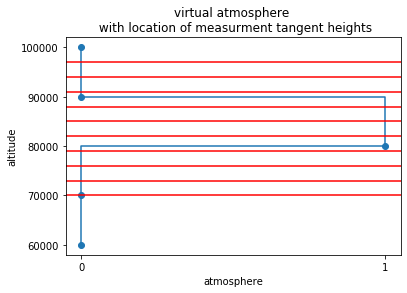

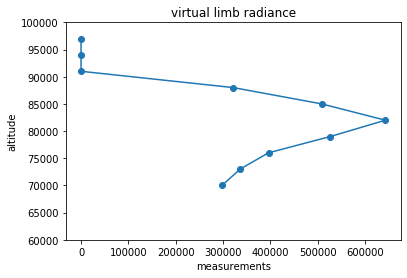

In [200]:
from geometry_functions import pathl1d_iris

tan_alt = np.arange(70e3, 100e3, 3e3)  # measurement grid is definded by tangent altitude
z = np.arange(60e3, 110e3, 10e3) # atmospheric grid
z_top = 150e3
K = pathl1d_iris(tan_alt, z, z_top)
v = np.zeros(z.shape) # virtual atmosphere / VER
v[2] = 1

plt.figure()
plt.step(v, z, marker='o')
for i in range(len(tan_alt)):
    plt.axhline(y=tan_alt[i], color='r')
plt.yticks(z)
plt.xticks([0,1])
plt.title('virtual atmosphere \n with location of measurment tangent heights')
plt.ylabel('altitude')
plt.xlabel('atmosphere')
plt.show()

plt.figure()
plt.scatter(K.dot(v), tan_alt)
plt.plot(K[:,2], tan_alt)
plt.title('virtual limb radiance')
plt.xlabel('measurements')
plt.ylabel('altitude')
plt.ylim(z.min(), z.max())
plt.show()




In [201]:
Re = 6370e3
np.sqrt((90e3+Re)**2-(np.arange(70e3, 100e3, 3e3)[4]+Re)**2) * 2 


642793.9016512213

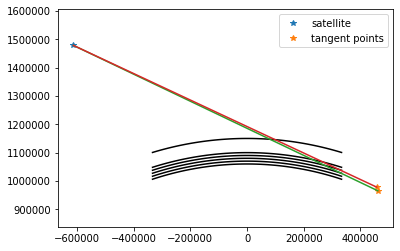

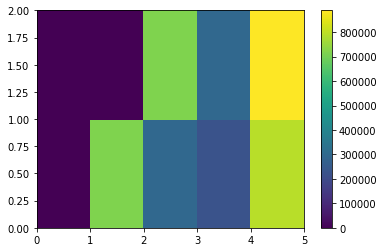

In [75]:
#visualize the layers and LOS 
Re = 1000e3#6370e3 # earth's radius in m
Sat = 600e3
beta = -np.pi/8 #angel between p_sat and y axis 
d_beta = np.arccos((tan_alt+Re)/(Sat+Re))
a = np.linspace(-Re/3, Re/3)
b = np.zeros((len(a), len(z)+1))
for i in range(len(z)+1):
    
    if i == len(z):
        b[:,i] = np.sqrt((Re+z_top)**2 - a**2)
    else:
        b[:,i] = np.sqrt((Re+z[i])**2 - a**2)
plt.figure()
plt.plot(a,b, 'k')
plt.plot(np.sin(beta)*(Sat+Re), np.cos(beta)*(Sat+Re), '*', label='satellite')
plt.plot(np.sin(beta+d_beta)*(tan_alt+Re), np.cos(beta+d_beta)*(tan_alt+Re), '*', label='tangent points')
plt.plot([np.sin(beta)*(Sat+Re), np.sin(beta+d_beta[0])*(tan_alt[0]+Re)], 
         [np.cos(beta)*(Sat+Re), np.cos(beta+d_beta[0])*(tan_alt[0]+Re)])
plt.plot([np.sin(beta)*(Sat+Re), np.sin(beta+d_beta[1])*(tan_alt[1]+Re)], 
         [np.cos(beta)*(Sat+Re), np.cos(beta+d_beta[1])*(tan_alt[1]+Re)])
plt.axis('equal')
plt.legend()
plt.show()

plt.figure()
plt.pcolormesh(K)
plt.colorbar()
plt.show()

# In the case of tomography retrieval (2D/ 3D)
Funcion 'los_points_fix_dl' is used to locate some points along the los with fixed distance. Function 'jacobian_row' is to compute pathlength corresponds to each measurement 

In [116]:
from geometry_functions import los_points_fix_dl
from oem_functions import jacobian_row

##### first we borrow some pointing vectors from ir database

In [203]:
from geometry_functions import lla2ecef
import pandas as pd
from osirisl1services.readlevel1 import open_level1_ir
from osirisl1services.services import Level1Services

channel = 3
orbit = 22015

ir = open_level1_ir(orbit, channel, valid=False)
tan_alt = ir.l1.altitude.sel(pixel=slice(14, 128, 10))
tan_lat = ir.l1.latitude.sel(pixel=slice(14, 128, 10))
tan_lon = ir.l1.longitude.sel(pixel=slice(14, 128, 10))
sc_pos = ir.l1.position_ecef
#l1 = ir.data.sel(pixel=slice(14, 128)) #/np.pi
mjd = ir.mjd.data
pixel = tan_alt.pixel.data

tan_x, tan_y, tan_z = lla2ecef(tan_lat, tan_lon, tan_alt)
tan_xyz = xr.concat([tan_x, tan_y, tan_z],
                    pd.Index(['x', 'y', 'z'], name='xyz'))

sc_look = (tan_xyz - sc_pos)/np.linalg.norm(tan_xyz-sc_pos, axis=0)

im_lst = np.arange(800,810)

In [204]:
#change tan points coordinate
n_zenith = sc_pos.isel(mjd=0)
n_crosstrack = np.cross(sc_look.isel(mjd=0, pixel=0), n_zenith)
n_vel = np.cross(n_zenith, n_crosstrack)
n_z = n_zenith/np.linalg.norm(n_zenith)
n_x = n_crosstrack/np.linalg.norm(n_crosstrack)
n_y = n_vel/np.linalg.norm(n_vel)

#====tangent points in alpha, beta, rho coordinate
from geometry_functions import cart2sphe, change_of_basis
from geometry_functions import ecef2lla
tan_alpha = []
tan_beta = []
tan_rho = []

for i in mjd[im_lst]:
    p_old = tan_xyz.sel(mjd=i)
#    p_new = change_of_basis(n_crosstrack, n_vel, n_zenith, p_old)
    p_new = change_of_basis(n_x, n_y, n_z, p_old)
    alpha, beta, rho = cart2sphe(p_new.sel(xyz='x'),
                                 p_new.sel(xyz='y'),
                                 p_new.sel(xyz='z')) 
    tan_alpha.append(alpha)
    tan_beta.append(beta)
    tan_rho.append(rho)
tan_alpha = xr.DataArray(tan_alpha, 
                         coords=[mjd[im_lst], pixel],
                         dims=['mjd', 'pixel'])
tan_beta = xr.DataArray(tan_beta, 
                        coords=[mjd[im_lst], pixel],
                        dims=['mjd', 'pixel'])
tan_rho = xr.DataArray(tan_rho, 
                       coords=[mjd[im_lst], pixel],
                       dims=['mjd', 'pixel'])

#### define the atmospheric grid in alpha beta rho space

In [205]:
#====define atmosphere grid (the bin edges)
edges_alpha = np.linspace(tan_alpha.min()-0.01,
                          tan_alpha.max()+0.01, 2) #radian
edges_beta = np.arange(tan_beta.min()-0.1,
                         tan_beta.max()+0.15, 0.02) #radian (resolution 0.2 degree in Degenstein 2004)
edges_rho = np.append(z,z_top) # meter
edges = edges_alpha, edges_beta, edges_rho

#====grid points for plotting
grid_alpha = np.append(edges_alpha - np.gradient(edges_alpha)/2, 
                       edges_alpha[-1]+np.gradient(edges_alpha)[-1]/2)
grid_beta = np.append(edges_beta - np.gradient(edges_beta)/2, 
                       edges_beta[-1]+np.gradient(edges_beta)[-1]/2)
grid_rho = np.append(edges_rho - np.gradient(edges_rho)/2, 
                       edges_rho[-1]+np.gradient(edges_rho)[-1]/2)

shape_tomo = (len(grid_alpha), len(grid_beta), len(grid_rho))
v = np.zeros(shape_tomo) #virtual atmosphere / VER
v[:, :,2] = 1

##### Pathlength calculation

In [206]:
#%% cal Jacobian

dl = 3e3 #fixed distance between all points
nop = 500 # choose number of points along the line
K_row_idx = []
K_col_idx = []
K_value = []
dll = dl * np.ones(nop) #temp
all_los_alpha, all_los_beta, all_los_rho = [], [], []
measurement_id = 0
for image in im_lst:
    #====generate points of los for all pixels in each image
    #====all points in cartesian coordinate relative to the space craft
    sc_look_new = change_of_basis(n_crosstrack, n_vel, n_zenith, 
                                  sc_look.isel(mjd=image))
    sc_pos_new = change_of_basis(n_crosstrack, n_vel, n_zenith, 
                                 sc_pos.isel(mjd=image))
    lx, ly, lz = los_points_fix_dl(sc_look_new, sc_pos_new, dl=dl, nop=nop)    
    #====convert xyz to alpha, beta, rho for all points
    los_alpha, los_beta, los_rho = cart2sphe(lx, ly, lz)
    all_los_alpha.append(los_alpha)
    all_los_beta.append(los_beta)
    all_los_rho.append(los_rho)
    
    #====build K
    for pix in pixel:#l1.pixel[l1.notnull().isel(mjd=image)]: 
        los = los_alpha.sel(pixel=pix), los_beta.sel(pixel=pix), los_rho.sel(pixel=pix)
        measurement_idx, grid_idx, pathlength = jacobian_row(dll, edges, los, measurement_id)
        K_row_idx.append(measurement_idx)
        K_col_idx.append(grid_idx)
        K_value.append(pathlength)
        measurement_id += 1
        
K_row_idx = np.concatenate(K_row_idx).astype('int')
K_col_idx = np.concatenate(K_col_idx).astype('int')
K_value = np.concatenate(K_value) # in meter

#==== create sparse matrix
#====num of columns & rows of jacobian
col_len = len(grid_alpha) * len(grid_beta) * len(grid_rho)
row_len = len(pixel)*len(im_lst)#l1.isel(mjd=im_lst).notnull().sum().item()

from scipy.sparse import coo_matrix
K_coo = coo_matrix((K_value, (K_row_idx, K_col_idx)), shape = (row_len, col_len))


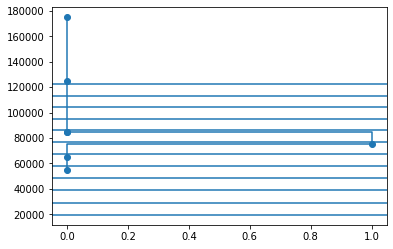

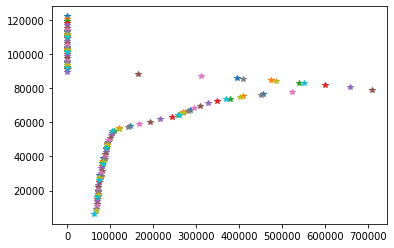

In [218]:
plt.figure()
plt.step(v[1,0,:].transpose(), grid_rho, marker='o')

for i in range(len(pixel)):
    plt.axhline(y=tan_alt.isel(mjd=im_lst[0], pixel=i), color='C0')
plt.show()

plt.figure()
plt.plot(K_coo.dot(v.ravel()).reshape((len(im_lst), len(pixel))).T,
            tan_alt.isel(mjd=im_lst).T, '*')
plt.show()